# 006_fastai_tabular_tricks

📙 This is my notes about the fastbook #9 Tabular, going through the Dataset (Blue-book-for-Bulldozers), to predict the 'SalePrice' by given features.

## Categorical Variables -> entity embeddings
- Entity embedding not only reduces memory usage and speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables... As entity embedding defines a distance measure for categorical variables it can be used for visualizing categorical data and for data clustering.
## Beyond deep learning
- the vast majority of datasets can be best modeled with just two methods:
  - Ensembles of decision trees: for sturctured data (databases of table at most companies)
  - Multilayered of nerual networds with SDG (shallow/deep learning): mainly for unstructured data (audio\images\natural language)

## Dataset: bluebook-for-bulldozers
Objective: Predict 'SalePrice' based on given features

In [1]:
#from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
import warnings
warnings.filterwarnings('ignore')

### Hide - Run if first time download

In [ ]:
creds = '{"username":"apple9855wang","key":"dd64a714207b1ee44d4da89abb2e0366"}'

In [ ]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
from kaggle import api
! kaggle competitions download -c bluebook-for-bulldozers
if not path.exists():
    path.mkdir(parents=true)
    file_extract(path/'bluebook-for-bulldozers.zip')

### Run from here: (Not first time)

In [2]:
path = Path("/Users/applewang//Desktop/Study_Materials_2023_2025/fastai_course/my-practice/bluebook-for-bulldozers")
Path.BASE_PATH = path

In [3]:
path.ls(file_type='text')

(#7) [Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('median_benchmark.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('TrainAndValid.csv')]

## Process the data

In [4]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.head(2)

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

### `add_datepart` function
transform the `saledate` into: 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
       'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start',
       'saleElapsed'

In [7]:
df = add_datepart(df,'saledate')

In [8]:
len(df.columns)

65

In [9]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [10]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)

In [11]:
dep_var = 'SalePrice'
df[dep_var] = np.log1p(df[dep_var])

### Using TabularPandas and TabularProc

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

**Condition here**: The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.
- train: before Nov,2011
- valid: Nov,2011 ~ Apr,2012
- potential problem: 按时间划分train/valid, 其数据分布可能不一致。

In [ ]:
procs = [Categorify, FillMissing]

condition = (df.saleYear<2011) | (df.saleMonth<10) 
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

splits = (list(train_idx),list(valid_idx))

cont, cat = cont_cat_split(df, max_card=1, dep_var=dep_var)

to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [17]:
len(to.train), len(to.valid)

(404710, 7988)

In [18]:
to.show(2)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097425
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950824


## Decision Tree

In [24]:
#save_pickle(path/'t.pkl',t) 
#to = load_pickle(path/'t.pkl')

In [19]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [20]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

(`draw_tree` from fastbook API)

In [21]:
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

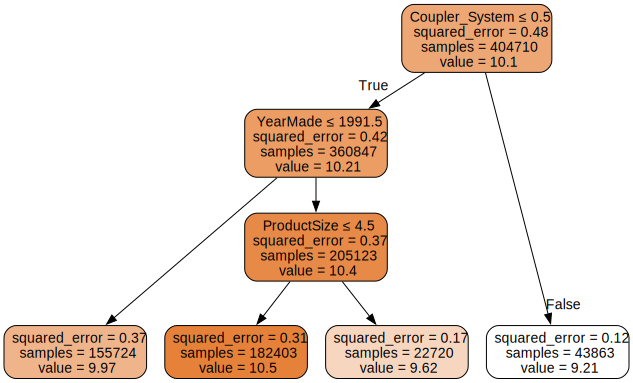

In [22]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

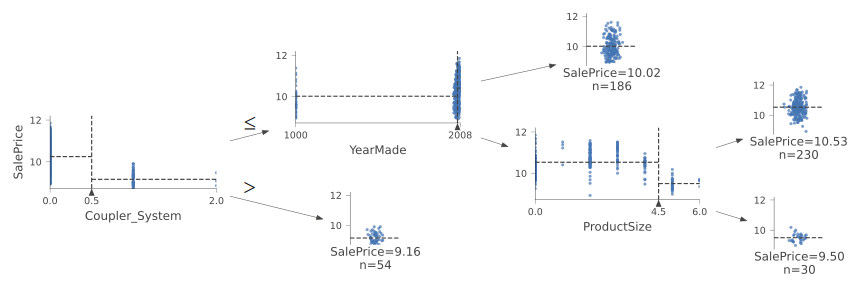

In [23]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [24]:
#Some YearMade=1000 - not reasonable -> change to 1950 may more reasonable.
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

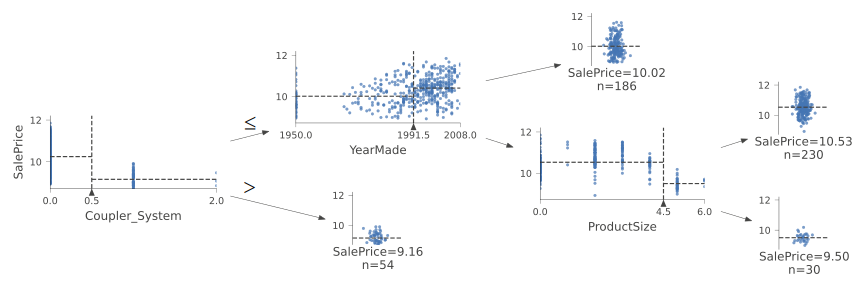

In [25]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [30]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

if no `max_leaf_nodes` here, it will create too many leaves! it will probably result in overfitting!

In [31]:
m = DecisionTreeRegressor() #create a tree with on limitation...
m.fit(xs,y)

DecisionTreeRegressor()

In [32]:
m_rmse(m, xs, y),m_rmse(m, valid_xs, valid_y) #clearly overfitting

(0.0, 0.334711)

In [33]:
m.get_n_leaves(), len(xs) #too much leaves, close to sample nums

(324565, 404710)

In [34]:
m = DecisionTreeRegressor(min_samples_leaf=25) #每个叶节点至少包含25个样本
m.fit(xs, y)
m_rmse(m, xs, y),m_rmse(m, valid_xs, valid_y)

(0.211695, 0.268746)

In [35]:
m.get_n_leaves()

12400

## Random forests
- `bagging` = 多个bag（模型）+ bootstrap(有放回的）+aggregate（聚合平均）--可以减少‘运气’的影响
- `OOB` out-of-bag -- 未被采样的样本，可以用来评估模型性能
- `oob_score=True` (default=False) -- Whether to use out-of-bag samples to estimate the generalization score. (By default, r2_score is used.) 方便后续可以调用`model.oob_prediction_`
- `max_samples`:int or float, default=None
- `min_samples_leaf`:int or float, default=1
- `max_features`:{“sqrt”, “log2”, None}, int or float, default=1.0; The number of features to consider when looking for the best split

In [36]:
def rf(xs, y, n_estimators=40, max_samples=200_000, 
       min_samples_leaf=5, max_features=0.5, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, 
                                 max_samples=max_samples, 
                                 min_samples_leaf=min_samples_leaf,
                                max_features=max_features,oob_score=True).fit(xs,y)

In [37]:
m = rf(xs,y)
m_rmse(m, xs, y),m_rmse(m, valid_xs, valid_y)

(0.171144, 0.233451)

average 40 trees here. A lot overfitting.

In [38]:
r_mse(m.oob_prediction_,y) #Prediction computed with out-of-bag estimate on the training set. 

0.210918

如果 OOB 错误率 比 验证集的 R_MSE 低，这可能意味着：

	1.	过拟合：模型可能在训练集上过拟合，导致在 OOB 样本上的表现优于验证集。
	2.	分布差异：OOB 样本与验证集的分布不同，导致 OOB 错误率较低，而验证集的表现较差。
	3.	模型偏向特定数据：模型在某些数据类型或特征组合上表现更好，而在验证集上的表现不如 OOB 样本。

## Model interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

### Tree variance for predict confidence

In [39]:
#tree variances of rf model
preds = np.stack([t.predict(valid_xs) for t in m.estimators_]) #rf set 40 n_estimators

In [40]:
preds.std(0)[:10]

array([0.23661989, 0.10111261, 0.12436234, 0.27283797, 0.12165818,
       0.25841754, 0.33368917, 0.33203955, 0.26020223, 0.20345435])

Each tree variance spread widely...might lead out low confidence, the predicted aution price may vary each time.

### Feature importance
- to examine whether some features can be ignored?
- `model.feature_importances_`:The higher, the more important the feature.

In [41]:
def rf_feat_importance(df, m):
    return pd.DataFrame({'col':df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [42]:
fi = rf_feat_importance(xs, m)
fi[:10]

,col,imp
57,YearMade,0.184640
30,Coupler_System,0.128589
6,ProductSize,0.124413
7,fiProductClassDesc,0.071976
54,ModelID,0.051361
65,saleElapsed,0.051079
3,fiSecondaryDesc,0.041034
31,Grouser_Tracks,0.037495
1,fiModelDesc,0.032529
32,Hydraulics_Flow,0.026647


In [43]:
def plot_fi(fi):
    return fi.plot('col','imp','barh', figsize=(8,6), legend=False)

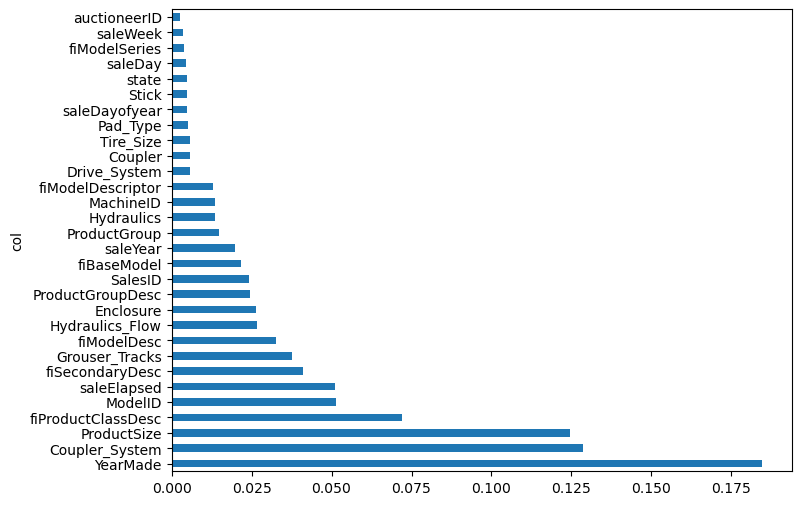

In [44]:
plot_fi(fi[:30]);

### remove low importance features

In [97]:
len(fi.col)

66

In [98]:
to_keep = fi[fi.imp>0.005].col

In [99]:
len(to_keep)

22

In [100]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [101]:
m = rf(xs_imp, y)
m_rmse(m, xs_imp,y), m_rmse(m, valid_xs_imp,valid_y)

(0.180945, 0.23215)

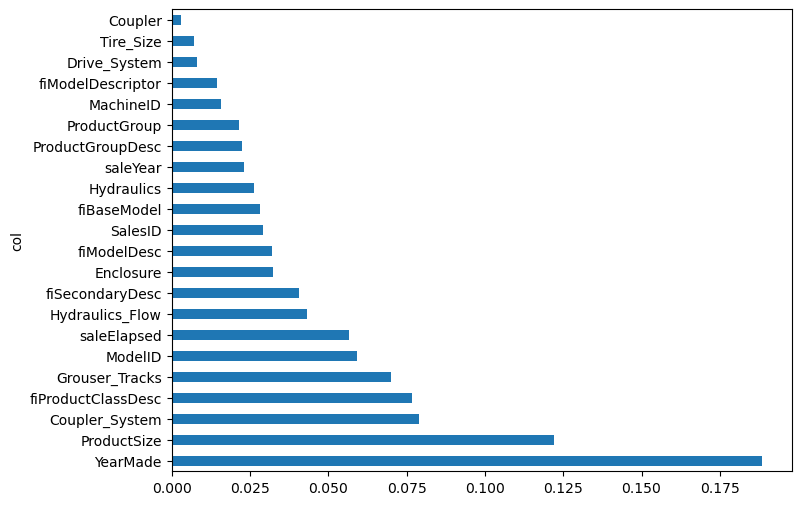

In [102]:
plot_fi(rf_feat_importance(xs_imp,m));

some features are redundant

In [103]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(8,6), font_size=8):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

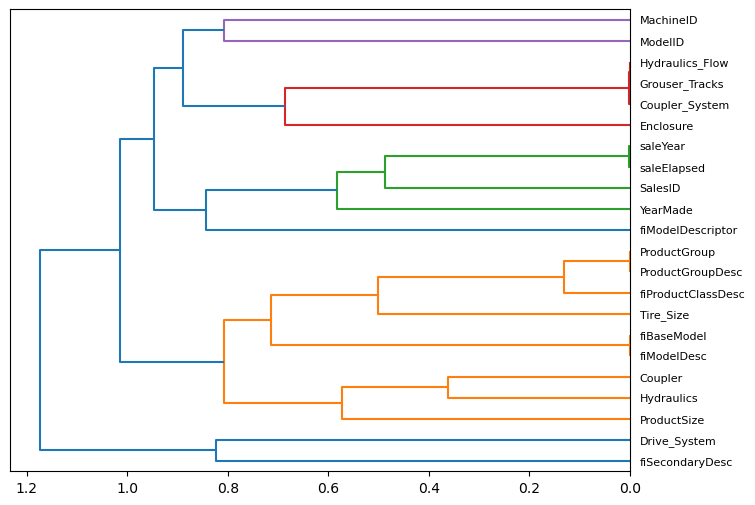

In [104]:
cluster_columns(xs_imp)

In [105]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=20,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return round(m.oob_score_,6)

In [106]:
get_oob(xs_imp) #baseline

0.871494

In [107]:
#check OOB if remove some features
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System','Coupler', 'Hydraulics', 'fiSecondaryDesc')}

{'saleYear': 0.87037,
 'saleElapsed': 0.866907,
 'ProductGroupDesc': 0.872529,
 'ProductGroup': 0.871295,
 'fiModelDesc': 0.869587,
 'fiBaseModel': 0.870572,
 'Hydraulics_Flow': 0.871811,
 'Grouser_Tracks': 0.872005,
 'Coupler_System': 0.87141,
 'Coupler': 0.87175,
 'Hydraulics': 0.871628,
 'fiSecondaryDesc': 0.867625}

In [112]:
to_drop = ['ProductGroupDesc','Hydraulics_Flow','Grouser_Tracks','Coupler']
get_oob(xs_imp.drop(to_drop, axis=1))

0.871726

In [113]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)
#save_pickle(path/'xs_final.pkl', xs_final)
#save_pickle(path/'valid_xs_final.pkl', valid_xs_final)
#xs_final = load_pickle(path/'xs_final.pkl')
#valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [114]:
len(xs_final.columns) #xs_imp has 22 features

18

In [115]:
m_final = rf(xs_final, y)
m_rmse(m_final,xs_final, y), m_rmse(m_final, valid_xs_final, valid_y)

(0.180709, 0.231264)

### partial dependence

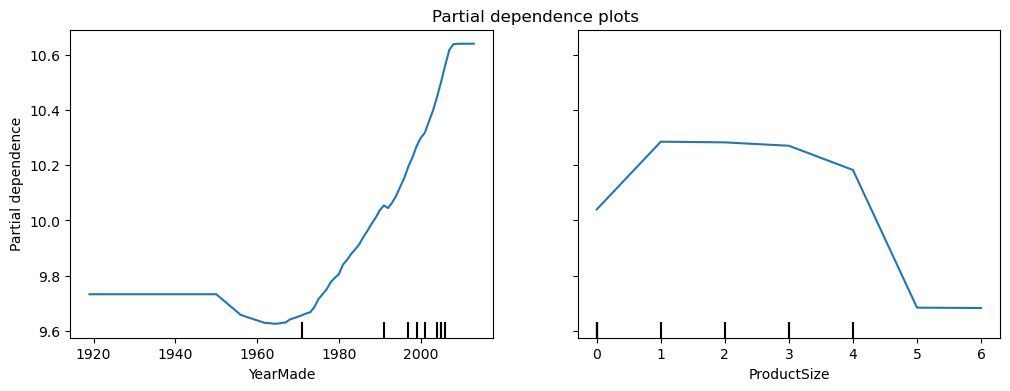

In [116]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Partial dependence plots")
display=PartialDependenceDisplay.from_estimator(m_final, valid_xs_final, ['YearMade','ProductSize'],ax=ax)

- Looking first of all at the `YearMade` ：PDP 图表明随着制造年份的增加，拍卖价格也相应地增加，这与我们预期的一致。通过对拍卖价格进行 对数变换，该关系表现为指数增长。这表明 价格的增长 是 时间累积效应 的结果，这符合 *贬值效应*：随着时间推移，设备贬值通常是一个 乘法因子，因此，较新的设备具有更高的拍卖价格。
    - 我们不需要对该特征进行进一步清洗，除非有明显的缺失或异常值。


- `ProductSize` 图形的变化和 缺失值的分布 可能表明 ProductSize 数据缺失的原因是 产品大小未定义或不重要，而这些缺失的样本对应着 价格较低 的设备。这可能反映出产品的 产品大小对价格有影响，并且缺失值可能表示这些设备没有明确的产品规格，通常意味着设备条件较差，导致低价格。
    - 警告：需要调查 缺失值的原因。如果缺失的 ProductSize 数据与设备的价格相关，这可能暗示着 **数据泄漏 data leakage**，即缺失数据本身可能包含有关预测目标的信息。如果缺失值与价格之间存在某种关系，可能会影响模型的性能。
    - 如果缺失值 确实与价格有关，我们应该考虑是否需要 删除缺失值样本，或者 通过其他特征推断 填补缺失值。

### Data leakage

- the most practical and simple approaches to identifying data leakage, which are to build a model and then:

    - Check whether the accuracy of the model is too good to be true.
    - Look for important predictors that don't make sense in practice.
    - Look for partial dependence plot results that don't make sense in practice.

### Tree interpreter + waterfall_chart
- treeinterpreter -- calculate "contributions" -- help to identify which features influence the specific predictions:
- `predictions = contributions (of features) + bias`
- waterfall -- visualize "contributions" -- identify the specific features from contributions

In [117]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [118]:
five_valids = valid_xs_final[:5]
predictions, bias, contributions = treeinterpreter.predict(m_final, five_valids.values)

In [119]:
#predictions = contributions + bias
predictions[0], bias[0], contributions[0].sum()

(array([9.98721415]), 10.104635888188241, -0.11742173791786101)

threshold=0.08 means factors>0.08 will be shown;

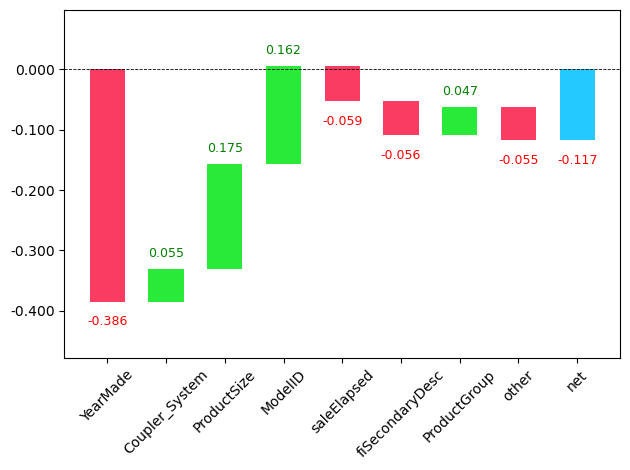

In [120]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, rotation_value=45, formatting='{:,.3f}'); 

This plot is more useful in production than model development; The specific prediction can be explained to your users.

## Extrapolation problem
- 外推问题（超出训练集以外的数据）Random forest预测能力有限--every tree built based on training data.

In [107]:
np.random.seed(42)
x_lin = torch.linspace(0,20,steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
xs_lin=x_lin.unsqueeze(1)

In [108]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30]) #only train first 30 datapoints, last 10 are unknown

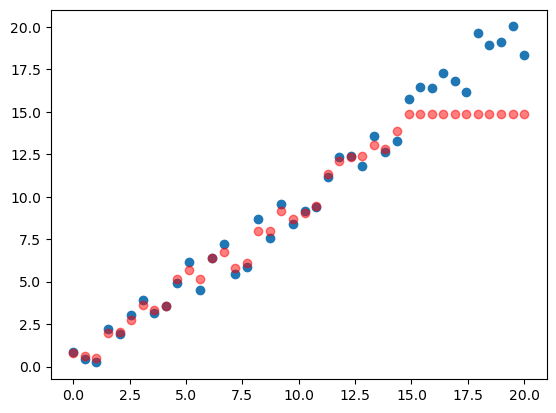

In [110]:
plt.scatter(x_lin, y_lin)
plt.scatter(x_lin, m_lin.predict(xs_lin),color='red', alpha=0.5);

Last 10 unseen data--prediction is poor here. So, we can use RF to identify what causes unseen features, affecting the poor performance. 
### Finding out-of-domain data
How to find that which feature will lead -> data leakage or unstable performance? 

In [132]:
#use rf to predict whether xs belongs to train or valid
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final)+[1]*len(valid_xs_final))
m = rf(df_dom, is_valid)
rf_feat_importance(df_dom, m)[:6]

,col,imp
5,saleElapsed,0.622122
11,saleYear,0.294424
9,SalesID,0.079419
14,MachineID,0.002711
0,YearMade,0.000686
13,Hydraulics,0.000141


In [133]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('saleElapsed','SalesID','MachineID','ModelID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231536
saleElapsed 0.230139
SalesID 0.22963
MachineID 0.229456
ModelID 0.234099


It shows that `SalesID` and `MachineID` will affect the accuracy (of predicting whether train or valid) more than `saleElapsed`. They lead the unstable situation \might increment over time. So, remove these two columns.

In [134]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m,xs_final_time, y) ,m_rmse(m, valid_xs_time, valid_y)

(0.188171, 0.229268)

It actually improves😁. 
- Previous: random forest (22 drop 4 redundant): (0.180709, **0.231264**)
- Now: drop 2 more features is better!

### Simply avoid old data

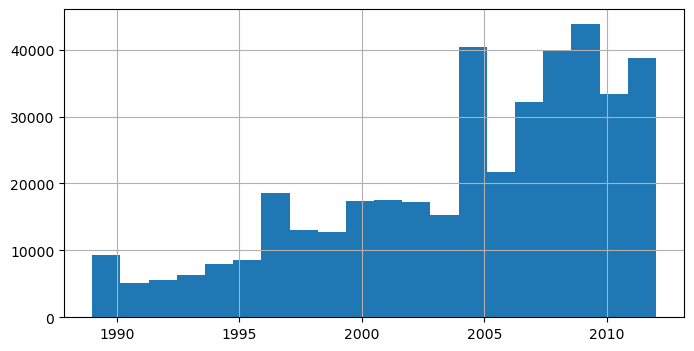

In [125]:
xs['saleYear'].hist(figsize=(8,4),bins=20);

In [135]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]
m=rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.173382, 0.228141)

## Comparison of rMSE (all machine learning models)
- decision tree(too much leaves): (0.0, 0.334711) *very overfitting*🤔

- decision tree (max_samples=25): (0.211695, 0.268746) *improving!* 😌

- random forest (40 trees with all features): (0.171144, 0.233451) *better but overfitting*🤓

- random forest (keep 22 features): (0.180945, 0.23215) *improving*😊

- random forest (22 drop 4 redundant): (0.180709, 0.231264) *improving*😁 `xs_final`

    - drop 2 features (SaleID, MachineID):(0.188171, 0.229268) *improving*😁 `xs_final_time`

    - simply avoid old data (saleYear>2005):(0.173382, 0.228141)) *improving*😁 `xs_filt`

## Use the Neural Network

### data process for nn

In [136]:
df_nn = pd.read_csv(path/"TrainAndValid.csv", low_memory=False)
df_nn['ProductSize']=df_nn['ProductSize'].astype('category')
df_nn['ProductSize'] = df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var]=np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [137]:
df_nn_final = df_nn[list(xs_final_time.columns)+ [dep_var]]
df_nn_final.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'fiSecondaryDesc', 'fiModelDesc', 'Enclosure',
       'fiBaseModel', 'saleYear', 'ProductGroup', 'Hydraulics',
       'fiModelDescriptor', 'Drive_System', 'Tire_Size', 'SalePrice'],
      dtype='object')

### Split to cont & cat

In [138]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [140]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
fiBaseModel           1961
saleYear                24
ProductGroup             6
Hydraulics              12
fiModelDescriptor      140
Drive_System             4
Tire_Size               17
dtype: int64

In [141]:
xs_filt2 = xs_filt.drop('fiModelDesc', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDesc', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.175946, 0.229757)

In [142]:
cat_nn.remove('fiModelDesc')

In [143]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(1024)

In [144]:
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

In [145]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.00015848931798245758)

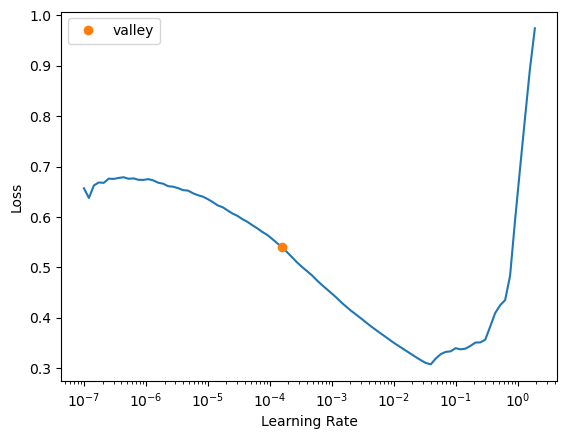

In [146]:
learn.lr_find()

In [147]:
learn.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,time
0,0.061012,0.073757,00:03
1,0.054827,0.065217,00:03
2,0.048071,0.057090,00:03
3,0.042407,0.052667,00:03
4,0.040089,0.050281,00:03


In [148]:
preds, targs = learn.get_preds()

In [149]:
r_mse(preds, targs)

0.224235

Quite better than previous best rf (0.228ish)

In [170]:
#learn.save('nn')

### ensembling
ensemble the rf predictions & nn predictions can also improve a bit~

In [150]:
#ensemble the rf predictions & nn predictions
rf_preds = m.predict(valid_xs_time)
nn_preds = to_np(preds.squeeze())
en_preds = (rf_preds+nn_preds)/2

In [151]:
r_mse(en_preds, valid_y)

0.220427

Quite better than NN (0.224ish)

### Comparison of rMSE
- Best random forest: 0.228141
- nn: 0.224235
- ensemble (rf+nn): 0.2204

### Boosting
- Bagging（Bootstrap Aggregating）：训练时，每个模型 从*原始训练集*中 *随机有放回地抽取子集* 来训练，所有模型并行训练，最后 *对多个模型的预测进行平均*或投票，从而减少方差。
    - random forest
- 而**Boosting**: 在训练时，模型是 顺序训练的，每个模型的训练都依赖于前一个模型的结果，后续模型 会加强对前一个模型错误分类的关注，减少偏差。
    - 例如：梯度提升机（GBM）、XGBoost、LightGBM 等都是基于 Boosting 的方法。
    - 优点
    	- 提高准确率 (尤其是对于复杂的任务)
    	- 强大的偏差降低能力
    	- 可以处理非线性问题

    - 缺点
    	- 容易过拟合
    	- 训练时间较长
    	- 不太适合噪声数据

One more technique that has gotten great results is to use embeddings learned by a neural net in a machine learning model.
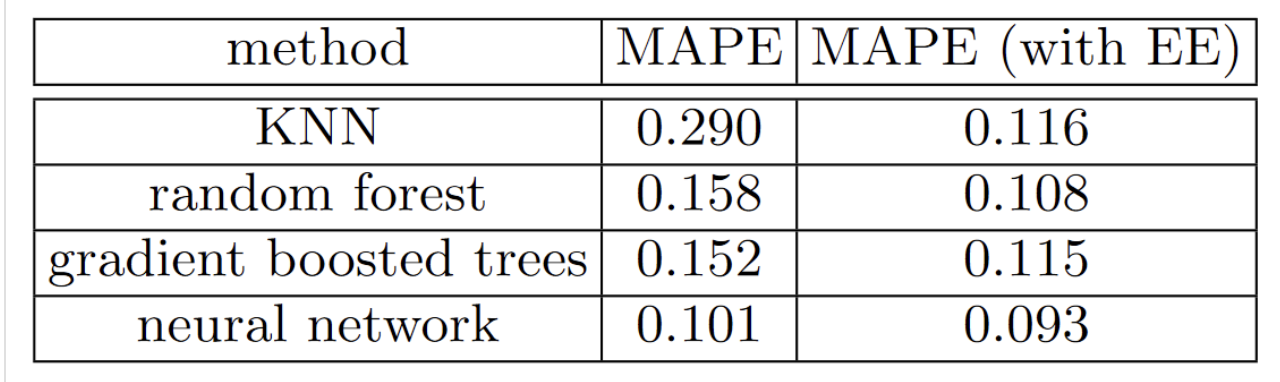
MAPE: mean average percent error

## Conclusion

- *Random forests* are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.

- *Gradient boosting machines* in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.

- *Neural networks* take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.
